# **0. Importación de librerías y definición de funciones**

> ## ***Librerías***

In [1]:
import pandas as pd
import numpy as np
import gzip # para procesar el archivo comprimido
import json # para tratar el json de las reviews
import matplotlib.pyplot as plt # visualización
from wordcloud import WordCloud # visualización
import nltk # exploración
from nltk import ngrams # exploración
from nltk.probability import FreqDist # exploracion

> ## ***Funciones***

In [2]:
def unzipping_json(ruta):
  """
  Carga los datos de un archivo comprimido gzip y los retorna como una lista.

  Parámetros:
  - ruta (str): La ruta al archivo comprimido.

  Retorna:
  - data (list): Lista de diccionarios cargados desde el archivo.
  """
  data = []
  with gzip.open(ruta) as f:
    for l in f:
      data.append(json.loads(l.strip()))
  return data

def sampled_per_class(df, num_samples):
  """
  Función para agrupar por clases deseadas y acotar número de reseñas por clase

  Parámetros:
  - df (pd.DataFrame): Dataframe que contiene las clases
  - num_samples (int): Número de muestras que se desean en cada clase

  Retorna:
  -  result_df (pd.DataFrame): Dataframe acotado y filtrado.
  """
  # Filtrado por clase
  dummie_df = df[df['overall'].isin([1, 2, 4, 5])]

  # Sampling por clase
  sampled_group = [dummie_df[dummie_df['overall'] == i].sample(n=num_samples, replace=True) for i in [1, 2, 4, 5]]

  # Concatenación de DataFrames
  result_df = pd.concat(sampled_group)

  return result_df


def word_cloud(text):
  """
  Función que crea y muestra una nube de las palabras más frecuentes en un texto

  Parámetros:
  - text (str): Texto del cuál tomará las palabras

  Retorna:
  No retorna ningún valor, retorna un gráfico de MatPlotLib de la nube de palabras WordCloud
  """
  # Configuración de la generación de la nube de palabras
  wordcloud = WordCloud(max_font_size=50,         ## máximo tamaño de letra en el gráfico
                        max_words=10,             ## número máximo de palabras
                        background_color="white"  ## color de fondo
                        ).generate(text)          ## texto del cuál WordCloud generará la nube

  # Tamaño del gráfico
  plt.figure(figsize=(20,10))

  # Configuración de los ejes de MatPlotLib
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off') ## sin ejes para mejor visualización

  # Mostrar el gráfico
  plt.show()

def show_ngrams(tokens, n):
  """
  Función que crea y muestra un gráfico en base al n-gramas más frecuentes
  dentro de una lista de tokens proporcionada

  Parámetros:
  - tokens (list): Lista de tokens de la cuál definirá el n-grama
  - n (int): Número que va a determinar el 'n'-grama (2 para bigramas, 3 para trigramas, etc)

  Retorna:
  No retorna un valor, muestra un gráfico de barras que representa la frecuencia
  de los 10 n-gramas más comunes.
  """
  # Enlista los n-gramas
  ngramas = list(ngrams(tokens, n))

  # Frecuencia de cada n-grama
  ng_freq = FreqDist(ngramas)

  # Filtrado por los 10 n-gramas más comunes
  ng_freq_most_common = ng_freq.most_common(10)

  # Extrae las label de los ngramas y las frecuencias para el gráfico
  ngs_ = [str(ng[0]) for ng in ng_freq_most_common]
  ngs_f_ = [ng[1] for ng in ng_freq_most_common]

  # Ordenado de los n-gramas por frecuencia
  ngs_f_, ngs_ = zip(*sorted(zip(ngs_f_, ngs_)))

  # Creación del gráfico de barras
  plt.barh(ngs_, ngs_f_)
  plt.title(f'Frecuencia de los {n}-gramas más comunes')
  plt.ylabel(f'{n}-gramas')
  plt.xlabel(f'Frecuencia')
  plt.show()

# **1. Descarga de los datos**

In [3]:
# Obtención de los datos
!wget -O 'datos-celulares.json.gz' 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz'

--2024-03-30 05:55:31--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169071325 (161M) [application/x-gzip]
Saving to: ‘datos-celulares.json.gz’

datos-celulares.jso 100%[===================>] 161.24M  1.32MB/s    in 60s     

2024-03-30 05:56:36 (2.69 MB/s) - ‘datos-celulares.json.gz’ saved [169071325/169071325]



In [4]:
ruta = 'datos-celulares.json.gz'
data = unzipping_json(ruta)

# Compruebo que el archivo se haya descomprimido correctamente
print(len(data))

1128437


In [5]:
# Paso la lista a DataFrame por comodidad
df = pd.DataFrame.from_dict(data)

# Borro registros que sean nulos de las columnas de mi interés
df.dropna(subset=['overall', 'reviewText'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Compruebo la integridad de los datos
print(len(df))

1127672


# **2. Exploración de los datos**

In [6]:
# Miro las columnas disponibles para posibles procedimientos
print(df.columns)

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image'],
      dtype='object')


**Me interesa quedarme con las columnas de las reviews que sean verificadas, para evitar posibles reviews sesgadas:**

In [7]:
# Miro cuántos cumplen o no con el criterio
print(df['verified'].value_counts())

True     986589
False    141083
Name: verified, dtype: int64


In [8]:
# Filtro por los que sí estén verificados
df_verified = df[df['verified'] == True]

print(df_verified['verified'].value_counts())

True    986589
Name: verified, dtype: int64


## **2.1 Distribución de reviews por número de estrellas**

**Otra cosa que me interesa, es saber cuántas muestras por clase *(columna 'overall')*, existen.**

In [9]:
print(df_verified['overall'].value_counts())

5.0    615667
4.0    157812
3.0     87899
1.0     73755
2.0     51456
Name: overall, dtype: int64


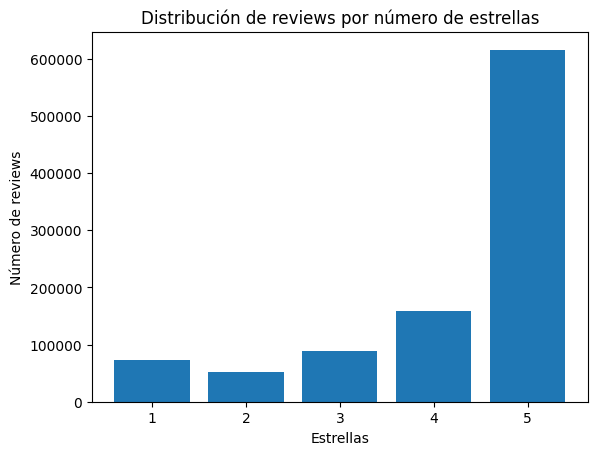

In [10]:
conteo = df_verified['overall'].value_counts()

plt.bar(conteo.index, conteo.values)

plt.title('Distribución de reviews por número de estrellas')
plt.ylabel('Número de reviews')
plt.xlabel('Estrellas')


plt.show()

> ### **Nº de reviews positivas y negativas**

In [11]:
# Se cuentan reviews positivas de 4 y 5 estrellas
reviews_positivas = df_verified[df_verified['overall'] >= 4].shape[0] # El shape[0] para que de una vez la variable sea el resultado int

# Se cuentan reviews negativas de 1 y 2 estrellas
reviews_negativas = df_verified[df_verified['overall'] <=2].shape[0]

print(f'Nro de reviews positivas: {reviews_positivas}')
print(f'Nro de reviews_negativas: {reviews_negativas}')

Nro de reviews positivas: 773479
Nro de reviews_negativas: 125211


Hay un muy claro desbalanceo, por lo que acoto el número de las muestras en un número fijo. Además que, enfoco de una vez la resolución en una de positivos-negativos (sin muestras neutras)

In [12]:
# Elección del número de muestras por clase
num_samples = 20000
result_df = sampled_per_class(df_verified, num_samples)

# Comprobación de las clases
print(result_df['overall'].value_counts()), print(len(result_df))

1.0    20000
2.0    20000
4.0    20000
5.0    20000
Name: overall, dtype: int64
80000


(None, None)

Para el caso de **NLP**, me interesan únicamente 2 columnas:

1. '**overall**': Me permite evaluar la valoración general del producto.

2. '**reviewText**': Me permite analizar las opiniones de maneras más específicas, además la elijo en vez de la columna 'summary' porque me parece que reviewText ofrece mayor profundidad de análisis.

No obstante, no quiero hacer entender que las demás columnas no aporten información, sino que para el propósito específico de mi análisis, estas dos columnas son las más relevantes.

In [13]:
df_filtered = result_df[['overall', 'reviewText']]

print(df_filtered.groupby('overall').sample(2)) # muestreo aleatorio de 2 reviews por clase

        overall                                         reviewText
95282       1.0  TOO sticky. Left residue and junk on my dash, ...
76748       1.0  Not worth the money. It barely charges my iPho...
723545      2.0  You cannot put the phone to charge with the pr...
29586       2.0  Nice looking case.....But if you want a screen...
118292      4.0  So far so good with this adapter. Generally, t...
412971      4.0  Reasonably priced, covers the phone well. I do...
877101      5.0                           fast shipping great case
779698      5.0  One of my favorite cases!  It provides the sup...


Una vez balanceadas las clases, guardo el archivo de los datos para poder hacer uso de estos próximamente

In [14]:
# Guardo en formato csv para al momento de su carga, seguir trabajando como un dataframe
df_filtered.to_csv('sampled_data_file.csv', index = False)

## **2.2 Cardinalidad del vocabulario**

Debido a que es una **exploración cruda** de los datos, se extraerá sin ningún tipo de preprocesamiento la cardinalidad, para darnos un resultado baseline para compararlo cuando se haga un análisis de cardinalidad con un preprocesado y ver cuánto ha cambiado

In [15]:
# Primero uno todas las reviews en un solo string
reviews = " ".join(df_filtered['reviewText'].astype(str))

# Luego se debe tokenizar cada palabra, lo dejo sin parámetros siendo así
# un poco más estricto que separarlo por espacios (' ')
tokens = reviews.split()

# Uso el 'set' para obtener todas las palabras únicas
unique_words = set(tokens)

print(len(unique_words))

91316


Nuevamente, hay que tener muy en cuenta que a este resultado no se le hizo literalmente ningún tipo de preprocesado, es un número bastante grande

## **2.3 Nube de palabras**



Para entender de una manera rápida de qué es lo que se está hablando en el texto, lo mejor es lo visual. Mediante una nube de palabras se ve con mucha más claridad información importante y frecuente

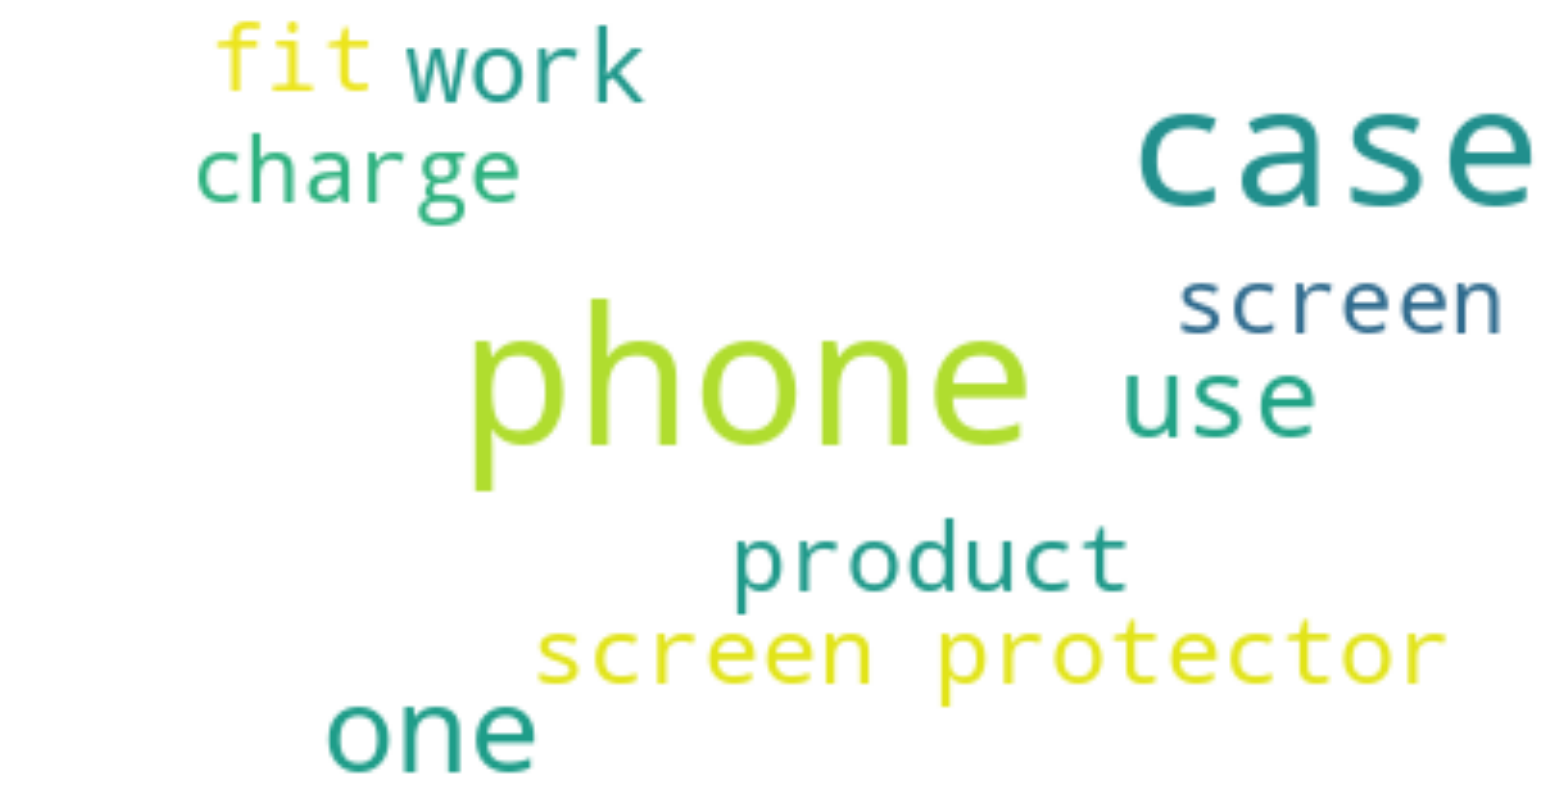

In [16]:
word_cloud(reviews)

## **2.4 N-gramas más frecuentes**

> ### ***Bigramas***

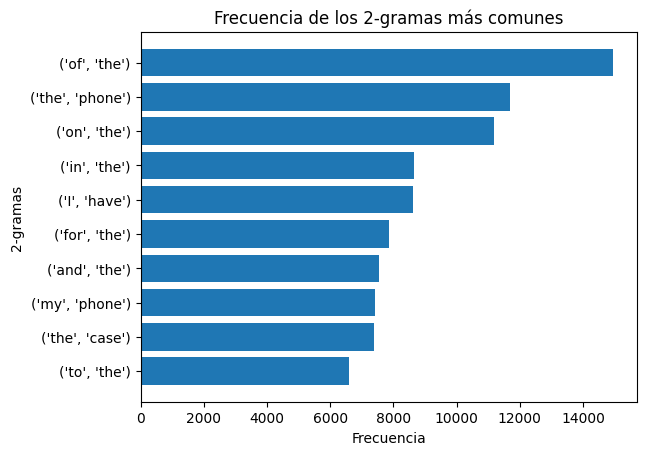

In [17]:
n = 2
show_ngrams(tokens, n)

No tiene mucho sentido la información puesto que no se le ha hecho ningún tipo de preprocesado a la misma. Aunque sí se alcanza a entender más o menos gracias a esto que se habla de teléfonos y protectores.

> ### ***Trigrama***

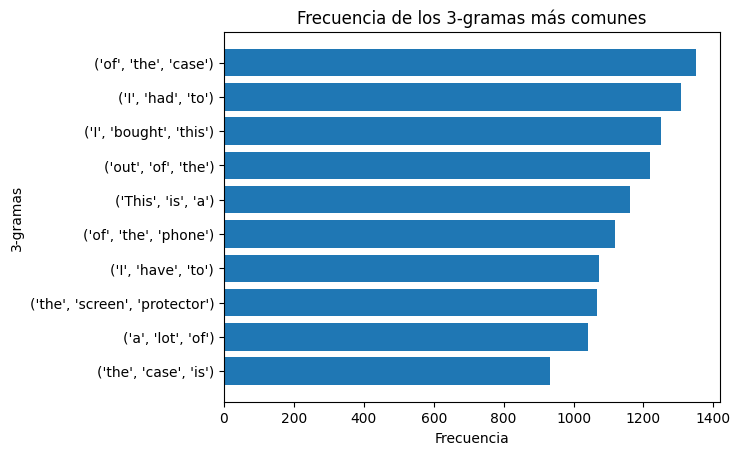

In [18]:
n = 3
show_ngrams(tokens, n)

Gracias a un trigrama se entiende mejor que las reviews tratan de accesorios para celulares, evidentemente, los resultados pueden mejorar cuando se les haga un preprocesamiento.

# **3. Conclusiones**

En sentidos generales, lo que se puede extraer del corpus inicial es una variedad de datos bastante buena, teniendo así potencial para análisis desde diferentes enfoques conjunto a NLP (Machine Learning y/o Deep Learning específicamente).

Además de ello, se evidencian dos cosas:

1. La mayoría de reviews son verificadas, lo que garantiza la calidad de los datos.

2. Las reviews en su mayoría son positivas, teniéndose que tener en cuenta para el análisis, ya que, se demostró que tienen un fuerte desbalanceamiento.

También, un conteo inicial para la cardinalidad del corpus arroja un resultado de más de 91.000 palabras. Siendo éste, un número que se reconoce como inflado debido a la ausencia total de preprocesamiento alguno. A pesar de esto, tanto en la nube de palabras como en los n-gramas se puede extraer información vital de cuál es el tema central de las reviews: Celulares y Accesorios de los mismos.

Esta primera parte sirve como un punto de referencia vital. Además, es **necesario** un procesamiento exhaustivo que permita una correcta y precisa exploración de los datos.